/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 0/100 | D Loss: 0.3345 | G Loss: 0.7367
Epoch 10/100 | D Loss: 0.5465 | G Loss: 0.5455
Epoch 20/100 | D Loss: 0.8237 | G Loss: 0.2273
Epoch 30/100 | D Loss: 1.0619 | G Loss: 0.1703
Epoch 40/100 | D Loss: 1.7300 | G Loss: 10.0426
Epoch 50/100 | D Loss: 0.3258 | G Loss: 2.2606
Epoch 60/100 | D Loss: 0.4808 | G Loss: 1.3062
Epoch 70/100 | D Loss: 0.2751 | G Loss: 4.6837
Epoch 80/100 | D Loss: 0.2348 | G Loss: 3.1712
Epoch 90/100 | D Loss: 0.3761 | G Loss: 2.5624


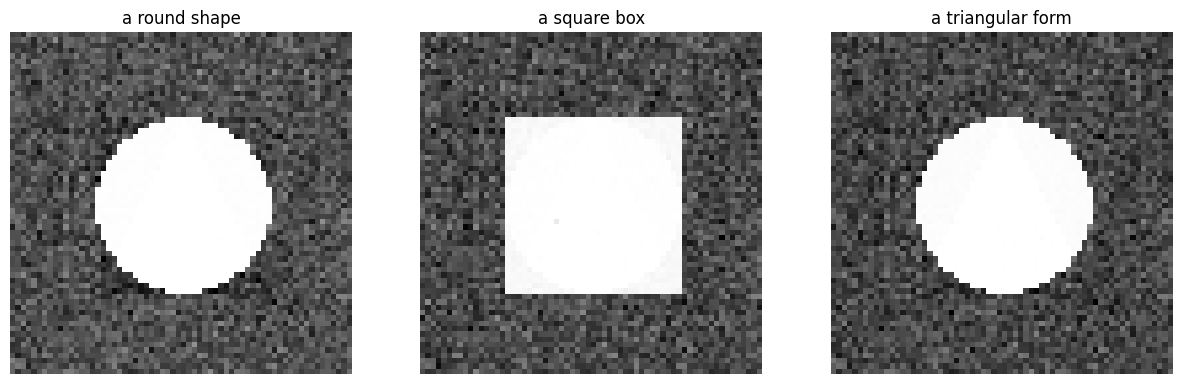

In [1]:
# Text-to-Image GAN Pipeline

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
from transformers import BertTokenizer, BertModel
import random
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
image_size = 64
latent_dim = 100
embedding_dim = 768  # From BERT
batch_size = 16
num_epochs = 100

# Dummy text to shape mapping for illustration
text_shape_mapping = {
    "a round shape": 0,
    "a square box": 1,
    "a triangular form": 2
}

# Generate shape from label
class ShapeTextDataset(Dataset):
    def __init__(self, tokenizer, length=300):
        self.length = length
        self.data = []
        self.tokenizer = tokenizer
        for _ in range(length):
            text, label = random.choice(list(text_shape_mapping.items()))
            image = self.create_shape_image(label)
            tokenized = self.tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=16)
            self.data.append((image, tokenized, label))

    def create_shape_image(self, label):
        img = Image.new('L', (image_size, image_size), color=0)
        draw = ImageDraw.Draw(img)
        if label == 0:
            draw.ellipse([16, 16, 48, 48], fill=255)
        elif label == 1:
            draw.rectangle([16, 16, 48, 48], fill=255)
        elif label == 2:
            draw.polygon([32, 16, 16, 48, 48, 48], fill=255)
        return transforms.ToTensor()(img)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image, tokens, label = self.data[idx]
        return image, tokens, label

# Load BERT model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").to(device)

# Generator
class Text2ImageGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, image_size * image_size),
            nn.Tanh()
        )

    def forward(self, noise, text_emb):
        x = torch.cat((noise, text_emb), dim=1)
        img = self.fc(x)
        return img.view(-1, 1, image_size, image_size)

# Discriminator
class Text2ImageDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(image_size * image_size + embedding_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, text_emb):
        x = torch.cat((img.view(img.size(0), -1), text_emb), dim=1)
        return self.fc(x)

# Prepare data
dataset = ShapeTextDataset(tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate models
generator = Text2ImageGenerator().to(device)
discriminator = Text2ImageDiscriminator().to(device)

# Loss and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training
for epoch in range(num_epochs):
    for imgs, tokens, _ in dataloader:
        real_imgs = imgs.to(device)
        input_ids = tokens['input_ids'].squeeze(1).to(device)
        attention_mask = tokens['attention_mask'].squeeze(1).to(device)
        with torch.no_grad():
            text_emb = bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output

        valid = torch.ones(real_imgs.size(0), 1).to(device)
        fake = torch.zeros(real_imgs.size(0), 1).to(device)

        # Generator
        optimizer_G.zero_grad()
        z = torch.randn(real_imgs.size(0), latent_dim).to(device)
        gen_imgs = generator(z, text_emb)
        g_loss = adversarial_loss(discriminator(gen_imgs, text_emb), valid)
        g_loss.backward()
        optimizer_G.step()

        # Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs, text_emb), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), text_emb), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Generate and show samples
def generate_and_show(text_prompts):
    generator.eval()
    with torch.no_grad():
        tokens = tokenizer(text_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
        text_emb = bert(**tokens).pooler_output
        z = torch.randn(len(text_prompts), latent_dim).to(device)
        gen_imgs = generator(z, text_emb).cpu()

        fig, axs = plt.subplots(1, len(text_prompts), figsize=(15, 5))
        for i in range(len(text_prompts)):
            axs[i].imshow(gen_imgs[i][0], cmap='gray')
            axs[i].set_title(text_prompts[i])
            axs[i].axis("off")
        plt.show()

# Example
generate_and_show(["a round shape", "a square box", "a triangular form"])
